In [1]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from hourglass104 import StackedHourglassNetwork
from preprocess import Preprocessor

In [2]:
%load_ext autoreload
%autoreload 2
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [58]:
model = StackedHourglassNetwork((256, 256, 3), 4, 1, 16)
model.load_weights('./models/model-v1.0.0-epoch-25-loss-1.1146.h5')

In [60]:
encoded = tf.io.read_file('./test.jpg')
image = tf.image.decode_jpeg(encoded)

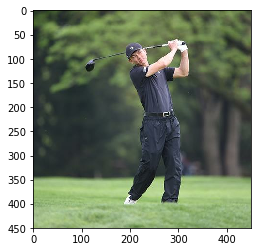

In [61]:
plt.imshow(image)
plt.show()

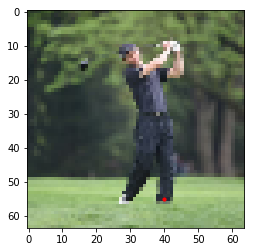

In [71]:
index = 2
image = tf.cast(image, dtype=tf.float32)
image = tf.image.resize(image, (256, 256))
inputs = image / 127.5 - 1.0
inputs = tf.expand_dims(inputs, axis=0)
outputs = model(inputs, training=False)

pd_kp = extract_keypoints_from_heatmap(outputs[3])
draw_keypoints_on_image(resized_image, pd_kp, 5)

In [6]:
a = tf.convert_to_tensor([[[1], [2], [3]],[[3], [4], [5]], [[9], [8], [7]]])
b = tf.reshape(a, (9, 1))
c = tf.math.argmax(b, axis=0)
d = tf.cast(c / 3, dtype=tf.int64)
e = c - 3 * d
print(d, e)
a[2][0]

tf.Tensor([2], shape=(1,), dtype=int64) tf.Tensor([0], shape=(1,), dtype=int64)


<tf.Tensor: shape=(1,), dtype=int32, numpy=array([9], dtype=int32)>

In [7]:
def extract_keypoints_from_heatmap(heatmaps):
    heatmaps = tf.squeeze(heatmaps, axis=0)
    flatten_heatmaps = tf.reshape(heatmaps, (4096, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    keypoint_y = tf.cast(indices / 64, dtype=tf.int64)
    keypoint_x = indices - 64 * keypoint_y
    keypoint = tf.stack([keypoint_x, keypoint_y], axis=1)
    return keypoint.numpy()

In [8]:
def draw_keypoints_on_image(image, keypoints, index=None):
    resized_image = tf.image.resize(image, (64, 64)) / 255
    fig,ax = plt.subplots(1)
    ax.imshow(resized_image)
    for i, joint in enumerate(keypoints):
#         if joint[0] <= 0 or joint[1] <= 0:
#             continue
        if index is not None and i != index:
            continue
        plt.scatter(joint[0], joint[1], s=10, c='red', marker='o')
    plt.show()

In [27]:
p = Preprocessor(is_train=True)
dataset = tf.data.Dataset.list_files('./dataset/tfrecords_mpii/val*.tfrecords')
dataset = tf.data.TFRecordDataset(dataset)
dataset = dataset.map(p)

images = []
heatmaps = [] 
for image, heatmap in dataset.take(5):
    images.append(image.numpy())
    heatmaps.append(heatmap.numpy())

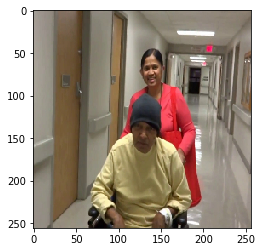

In [28]:
plt.imshow((images[0]+1) * 127.5 / 255)
plt.show()

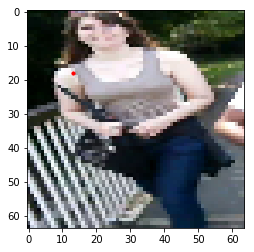

In [29]:
index = 2
label = tf.convert_to_tensor(heatmaps[index])
label = tf.expand_dims(label, axis=0)
image = (images[index]+1) * 127.5
gt_kp = extract_keypoints_from_heatmap(label)
draw_keypoints_on_image(image, gt_kp, 12)

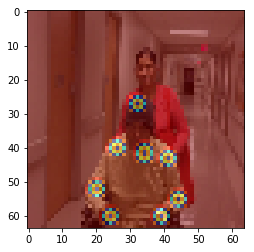

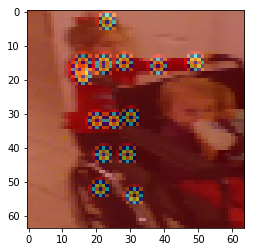

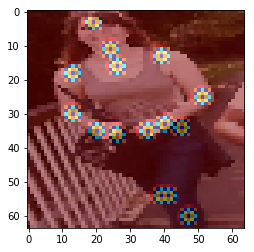

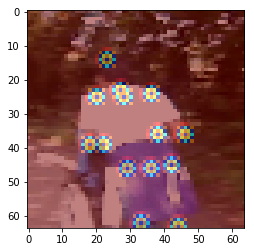

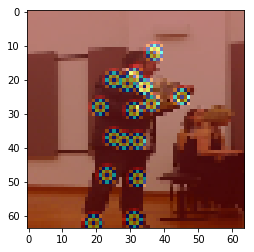

In [30]:
import cv2
import numpy as np

for image, heatmap in zip(images, heatmaps):
    image = (image + 1) * 127.5
    
    image = cv2.resize(image.astype(np.uint8), dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
#     plt.imshow(image)
#     plt.show()
    combined_map = np.amax(heatmap, axis=2) * 255
    heatmap_image = cv2.applyColorMap(combined_map.astype(np.uint8), cv2.COLORMAP_JET)
#     plt.imshow(heatmap_image)
#     plt.show()
    overlayed = cv2.addWeighted(heatmap_image, 0.5, image, 0.5, 0)
    plt.imshow(overlayed)
    plt.show()

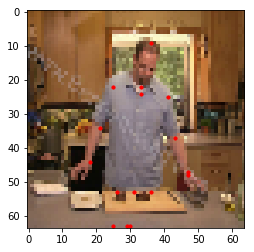

In [59]:
index = 2
image = (images[index]+1) * 127.5
inputs = images[index]
inputs = tf.expand_dims(inputs, axis=0)
outputs = model(inputs, training=False)
labels = heatmaps[index]
pd_kp = extract_keypoints_from_heatmap(outputs[3])
draw_keypoints_on_image(image, pd_kp)

# tf.print(outputs[3][:,:,:,8], summarize=-1)

## diff = label[:,:,:,8] - outputs[3][:,:,:,8]
tf.print(tf.reduce_sum(tf.math.square(diff)), summarize=-1)

In [15]:
loss_obj = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)

In [35]:

loss = 0
for output in outputs:
    # assign more weights to foreground pixels
    weights = tf.cast(labels > 0, dtype=tf.float32) * 2 + 1
    # loss += tf.reduce_mean(self.loss_object(
    #    labels, output)) * (1. / self.global_batch_size)
    # loss += tf.math.reduce_sum(tf.math.reduce_mean(tf.math.square(labels - output) * weights, axis=[0,1,2])) * (1. / self.global_batch_size)
    loss += tf.math.reduce_mean(tf.math.square(labels - output) * weights)

print(loss)
# loss1 = 0
# loss2 = 0
# for output in outputs:
#     loss1 += tf.math.reduce_mean(tf.math.square(label - output))
#     loss2 += tf.math.reduce_mean(loss_obj(label, output))
# tf.print(loss1, summarize=-1)
# tf.print(loss2, summarize=-1)

tf.Tensor(1.8492734, shape=(), dtype=float32)


In [17]:
loss = 0
for output in outputs:
    loss += tf.math.square(label - output)

In [18]:
tf.print(label[:,:,:,9], summarize=-1)

[[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.00148091768 0.0180412699 0.0808553621 0.133307964 0.0808553621 0.0180412699 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.0180412699 0.219787672 0.98502 1.62402344 0.98502 0.219787672 0 0 0 0 0 0 0 0 0 0 0

In [19]:
tf.print(tf.clip_by_value(tf.math.square(label[:,:,:,9] - outputs[0][:,:,:,9]), 0.1, 1), summarize=-1)

[[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.207972497 0.388637334 0.276590765 0.288228571 0.257683367 0.196059793 0.105549924 0.244347408 0.217187375 0.199682489 0.1 0.1 0.102521986 0.1 0.110034317 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.154559568 0.248048902 0.869383514 0.655752897 0.409569621 0.254981399 0.250103652 0.160556689 0.1 0.181286827 0.170038715 0.195211604 0.1 0.1 0.213500604 0.130234599 0.172735482 0.122788139 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
  [0.233065575 0.255779564 0.629881203 0.744495869 0.575340331 0.335941046 0.129125282 0.147256583 0.330793768 0.308734924 0.184981927 0.183279887 0.252798527 0.308780968 0.418331802 0.450114697 1 0.738318 0.290261567 0.232941136 0.1 0.1 0.1 0.1 0.1 0.1 0.16151608

In [20]:
import numpy as np

sigma = 64/64
size = 6*sigma + 3
x = np.arange(0, size, 1, float)
y = x[:, np.newaxis]
x0, y0 = 3*sigma + 1, 3*sigma + 1
g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

In [21]:
g

array([[1.12535175e-07, 3.72665317e-06, 4.53999298e-05, 2.03468369e-04,
        3.35462628e-04, 2.03468369e-04, 4.53999298e-05, 3.72665317e-06,
        1.12535175e-07],
       [3.72665317e-06, 1.23409804e-04, 1.50343919e-03, 6.73794700e-03,
        1.11089965e-02, 6.73794700e-03, 1.50343919e-03, 1.23409804e-04,
        3.72665317e-06],
       [4.53999298e-05, 1.50343919e-03, 1.83156389e-02, 8.20849986e-02,
        1.35335283e-01, 8.20849986e-02, 1.83156389e-02, 1.50343919e-03,
        4.53999298e-05],
       [2.03468369e-04, 6.73794700e-03, 8.20849986e-02, 3.67879441e-01,
        6.06530660e-01, 3.67879441e-01, 8.20849986e-02, 6.73794700e-03,
        2.03468369e-04],
       [3.35462628e-04, 1.11089965e-02, 1.35335283e-01, 6.06530660e-01,
        1.00000000e+00, 6.06530660e-01, 1.35335283e-01, 1.11089965e-02,
        3.35462628e-04],
       [2.03468369e-04, 6.73794700e-03, 8.20849986e-02, 3.67879441e-01,
        6.06530660e-01, 3.67879441e-01, 8.20849986e-02, 6.73794700e-03,
        2.0